<a href="https://colab.research.google.com/github/ZahraDehghani99/Heart-Disease-Health-Indicators-Dataset/blob/main/heart_disease_classification_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Disease Classification

In this notebook we want to use normal data ( 	HeartDiseaseorAttack ==0) and data with  	HeartDiseaseorAttack ==1 separatly in the model. 
1. In the beginning we should separate these data in training data then we use normal data to train Autoencoder. After training autoencoder, we should check loss functions in the cross valiation iterations and select max loss fuction as a threshold. we use this threshold in the test phase to show that the test data with loss functions greater than threshold belongs to anoml data (heart disease) and the test data with loss functions smaller than threshold belongs to normal data.

2. then we train two separate model for each classes and give the test model to the both of them and check the probability of predicting label.

## Read data and EDA

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cd /content/drive/MyDrive/ML_Dr.sajedi/final_proj
# !unzip -q archive.zip

### Data Description
In this notebook, we want to do binary classification. We want to recognize a person has heart disease(1) or not(0) based on some health indicators.

These data are extracted from original data from CDC (centers for disease control and prevention) whose name is [BRFSS](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system) (behavioral risk factor surveillance system) which consists of 441456 rows and 330 columns. We worked with the cleaned BRFSS version which consists of 22 columns. 

In this data, `HeartDiseaseorAttack` is a target variable and other columns are feature variables.





| Categorical Features      |  Numerical Features    |
| --------------------------| ------------------     |
|  HighBP                   |      BMI              |
|  HighChol                 |      MentHlth         |
|  CholCheck                |      PhysHlth         |
|  Smoker  
|  Stroke
| Diabetes 	
|  PhysActivity 	
|  Fruits 	
|  Veggies 	
|  HvyAlcoholConsump 	
|  AnyHealthcare 	
| NoDocbcCost (no doctor because of cost)	
| GenHlth (1 excellent and 5 poor)      (ordinalvariable)       
|DiffWalk                 
| Sex                      
|  Age    (ordinal variable)                 
|  Education               (ordinal variable)         
|  Income                   (ordinal variable)



In [3]:
DATA_PATH = '/content/drive/MyDrive/ML_Dr.sajedi/final_proj/heart_disease_health_indicators_BRFSS2015.csv'
df = pd.read_csv(DATA_PATH)
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
print(f'data shape : {df.shape}')

data shape : (253680, 22)


In [5]:
print(f'data columns type : \n{df.dtypes}')

data columns type : 
HeartDiseaseorAttack    float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
Diabetes                float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object


In [ ]:
print(f'number of unique values in each column : \n{df.nunique()}')

number of unique values in each column : 
HeartDiseaseorAttack     2
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
Diabetes                 3
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64


As you can see MentHlth has 31 unique values.

In [ ]:
print(f'unique values of MentHlth : {df.MentHlth.unique()}')

unique values of MentHlth : [18.  0. 30.  3.  5. 15. 10.  6. 20.  2. 25.  1.  4.  7.  8. 21. 14. 26.
 29. 16. 28. 11. 12. 24. 17. 13. 27. 19. 22.  9. 23.]


Let's check for missing values in our data.

In [ ]:
print(f'number of null values in data : {df.isnull().sum().sum()}')

number of null values in data : 0


In [ ]:
df.describe()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.094186,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.296921,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.292087,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.698160,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


### Correlation matrix

We can choose features that have more than 0.5 correlation with target.

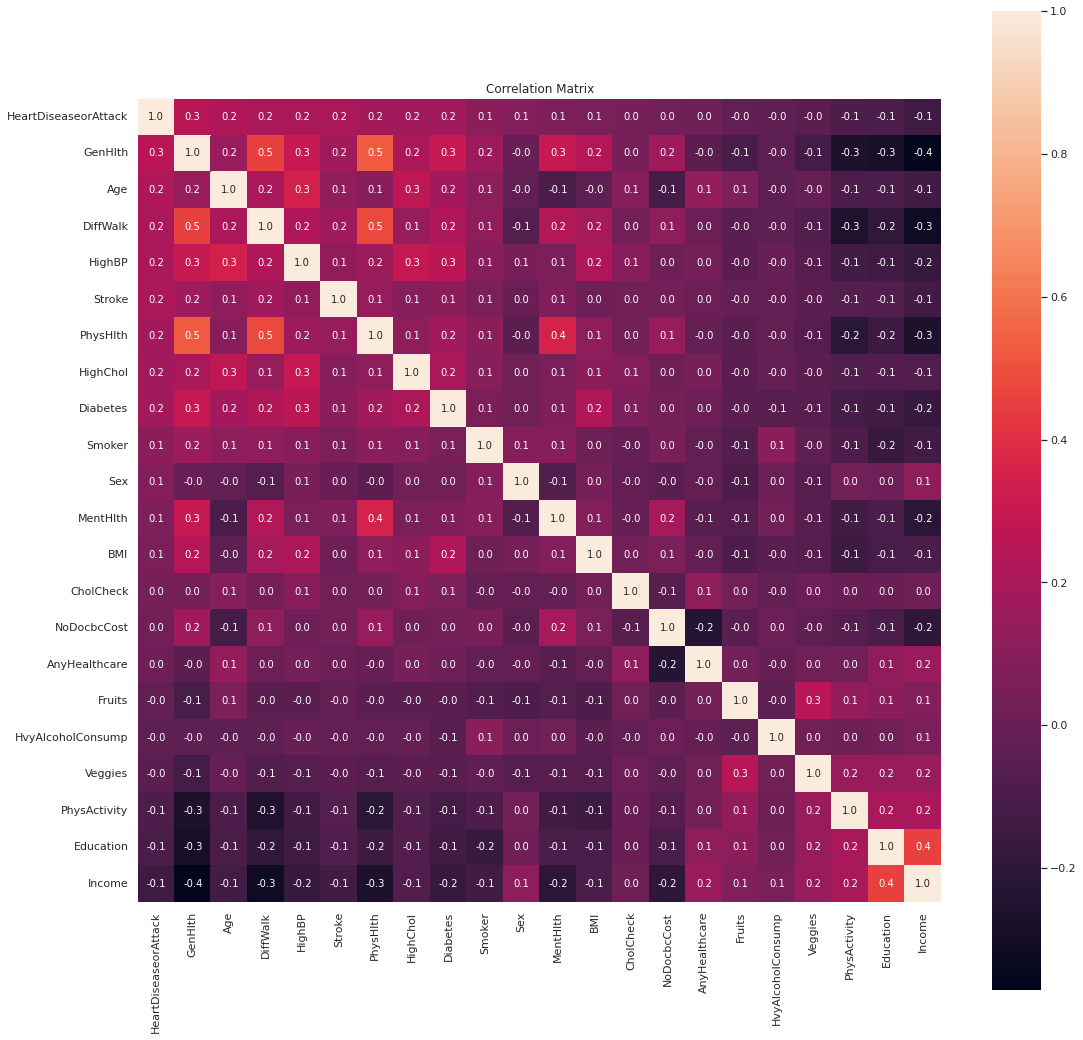

In [ ]:
# correlation matrix
correlation_matrix = df.corr()
k = 22 # number of variables for heatmap
cols = correlation_matrix.nlargest(k,'HeartDiseaseorAttack')['HeartDiseaseorAttack'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(18,18))  # Sample figsize in inches
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.01f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,ax=ax)
plt.title("Correlation Matrix")
plt.show()

we can choose features with more than o.2 correlation with output.

In [ ]:
#Correlation with output variable #TODO
cor_target = abs(correlation_matrix['HeartDiseaseorAttack'])

# #Selecting highly correlated features
# relevant_features = cor_target[cor_target>0.2]
# len(relevant_features)


In [ ]:
cor_target

HeartDiseaseorAttack    1.000000
HighBP                  0.209361
HighChol                0.180765
CholCheck               0.044206
BMI                     0.052904
Smoker                  0.114441
Stroke                  0.203002
Diabetes                0.180272
PhysActivity            0.087299
Fruits                  0.019790
Veggies                 0.039167
HvyAlcoholConsump       0.028991
AnyHealthcare           0.018734
NoDocbcCost             0.031000
GenHlth                 0.258383
MentHlth                0.064621
PhysHlth                0.181698
DiffWalk                0.212709
Sex                     0.086096
Age                     0.221618
Education               0.099600
Income                  0.141011
Name: HeartDiseaseorAttack, dtype: float64

In [ ]:
# # distribution of first 16 features
# fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(30, 20))
# axs = axs.flatten()
# index = 0
# for k, v in df.items():
#   sns.distplot(v, ax=axs[index])
#   index += 1
#   if index == 21:
#     break 
# plt.tight_layout()

In [ ]:
df.HeartDiseaseorAttack.value_counts()

0.0    229787
1.0     23893
Name: HeartDiseaseorAttack, dtype: int64

### Drop Duplicated rows

In [6]:
duplicated_rows = df[df.duplicated()]
print(f'we have {duplicated_rows.shape[0]} duplicated rows in our data.')

we have 23899 duplicated rows in our data.


In [ ]:
df.loc[df.duplicated(), :]

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
1242,0.0,1.0,1.0,1.0,27.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,30.0,1.0,0.0,10.0,4.0,5.0
1563,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
2700,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
3160,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
3332,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253492,0.0,1.0,1.0,1.0,33.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,9.0,6.0,6.0
253550,0.0,0.0,0.0,1.0,25.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,6.0,8.0
253563,0.0,0.0,1.0,1.0,24.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,6.0,8.0
253597,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0


let's drop duplicated rows.

In [7]:
df.drop_duplicates(inplace=True)
print(f'data shape after drop duplicated rows : {df.shape}')

data shape after drop duplicated rows : (229781, 22)


### Split X and y

In [8]:
X = df.drop(columns='HeartDiseaseorAttack')
y = pd.DataFrame(df['HeartDiseaseorAttack'])

print(f'X shape : {X.shape}')
print(f'y shape : {y.shape}')

X shape : (229781, 21)
y shape : (229781, 1)


Let's take a look at target value distribution.

In [ ]:
y.value_counts()

HeartDiseaseorAttack
0.0                     206064
1.0                      23717
dtype: int64

As we can see, we have imbalanced dataset.

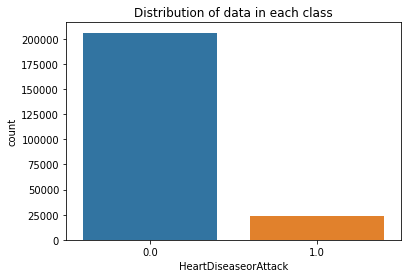

In [ ]:
# distribution of data in each class
sns.countplot(x="HeartDiseaseorAttack", data=y)
plt.title("Distribution of data in each class")
plt.show()

### Split train and test set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (183824, 21)
X_test shape: (45957, 21)
y_train shape: (183824, 1)
y_test shape: (45957, 1)


### Standardization

Let's standardize only numerical columns and ordinal features with more than 2 unique values.

In [10]:
from sklearn.preprocessing import StandardScaler

num_cols = ["BMI", "MentHlth", "PhysHlth"]
cat_ordinal = ["GenHlth", "Diabetes", "Age", "Education", "Income"]
should_sc= num_cols + cat_ordinal
sc = StandardScaler()
X_train[should_sc] = sc.fit_transform(X_train[should_sc])
X_test[should_sc] = sc.transform(X_test[should_sc])

In [ ]:
X_train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
82362,1.0,0.0,1.0,-0.249055,1.0,0.0,-0.448896,0.0,0.0,0.0,0.0,1.0,0.0,2.251163,3.438176,2.796650,1.0,0.0,0.617706,-0.988815,-2.337071
251920,0.0,0.0,1.0,-1.426816,1.0,0.0,-0.448896,1.0,1.0,1.0,0.0,1.0,0.0,-0.565182,-0.454350,-0.517075,0.0,0.0,0.940686,0.019086,1.008672
188598,1.0,0.0,1.0,2.400908,0.0,0.0,-0.448896,1.0,1.0,1.0,0.0,1.0,0.0,1.312382,-0.065098,0.035213,1.0,0.0,-0.028253,-0.988815,0.052746
171570,1.0,1.0,1.0,-0.396275,1.0,0.0,-0.448896,0.0,1.0,1.0,0.0,1.0,0.0,-1.503964,-0.454350,-0.517075,0.0,1.0,0.617706,-0.988815,1.008672
71721,1.0,1.0,1.0,0.487046,0.0,1.0,2.312886,0.0,1.0,1.0,0.0,1.0,0.0,0.373600,-0.454350,2.796650,1.0,0.0,1.263665,0.019086,-1.381144


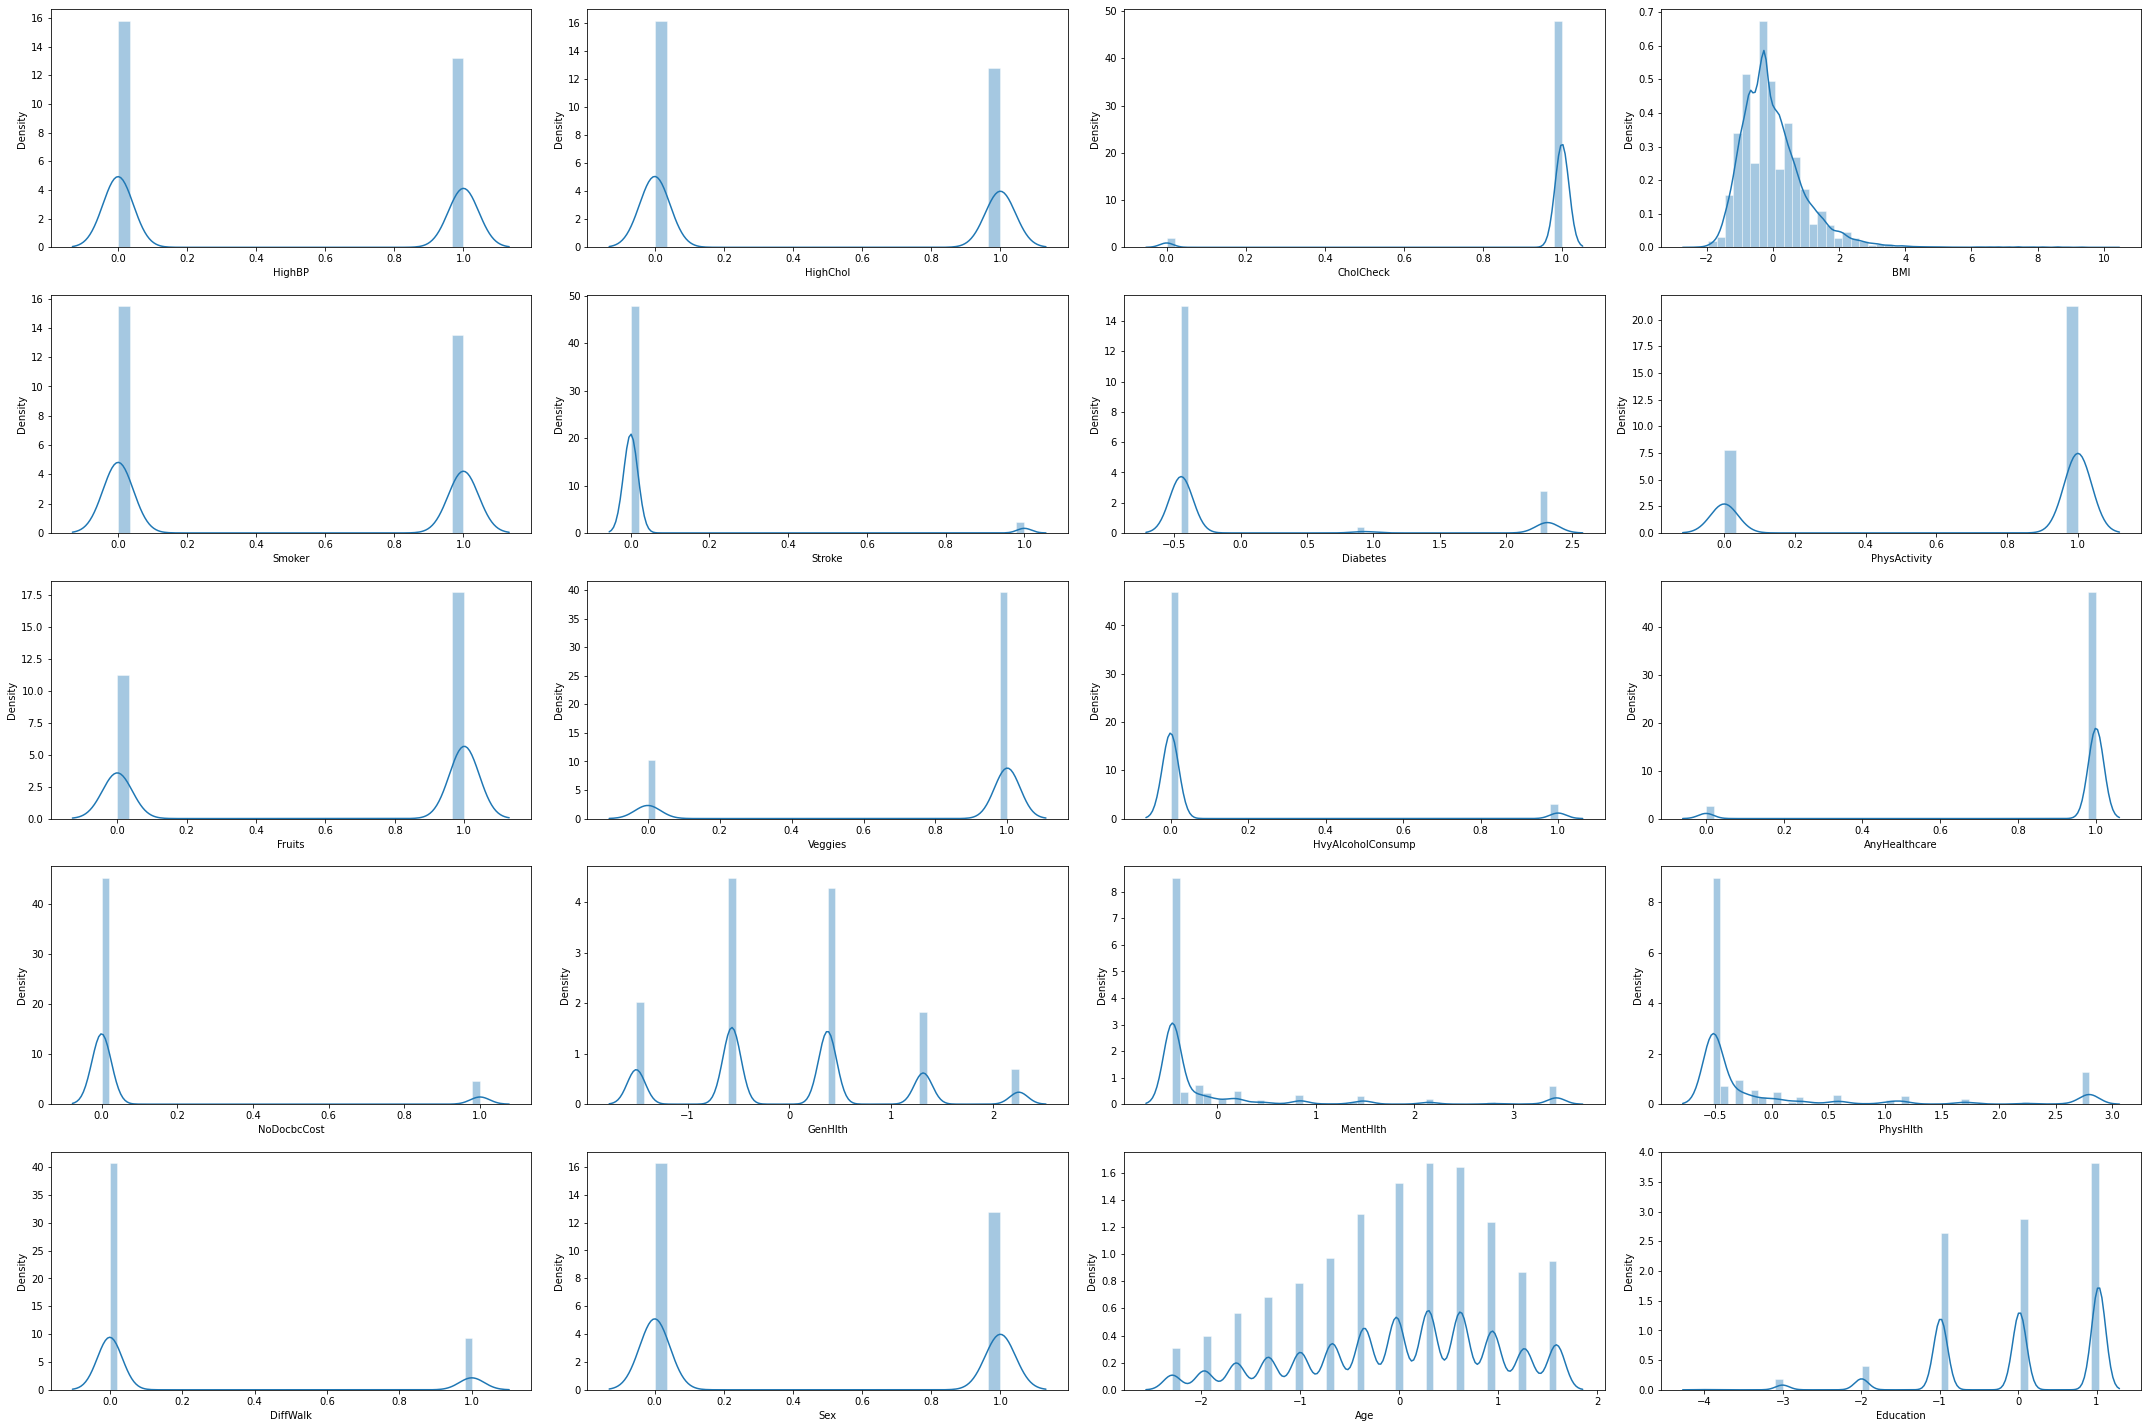

In [ ]:
# distribution of first 20 features
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(30, 20))
axs = axs.flatten()
index = 0
sns.set(font_scale = 1)
for k, v in X_train.items():
  sns.distplot(v, ax=axs[index])
  index += 1
  if index == 20:
    break 
plt.tight_layout()

Let's save the dataframe after standardization.

In [ ]:
# X_train.to_pickle("/content/drive/MyDrive/ML_Dr.sajedi/final_proj/X_train_heart.pkl")
# X_test.to_pickle("/content/drive/MyDrive/ML_Dr.sajedi/final_proj/X_test_heart.pkl")
# y_train.to_pickle("/content/drive/MyDrive/ML_Dr.sajedi/final_proj/y_train_heart.pkl")
# y_test.to_pickle("/content/drive/MyDrive/ML_Dr.sajedi/final_proj/y_test_heart.pkl")

Let's load them.

In [11]:
X_train = pd.read_pickle("/content/drive/MyDrive/ML_Dr.sajedi/final_proj/X_train_heart.pkl")
X_test = pd.read_pickle("/content/drive/MyDrive/ML_Dr.sajedi/final_proj/X_test_heart.pkl")
y_train = pd.read_pickle("/content/drive/MyDrive/ML_Dr.sajedi/final_proj/y_train_heart.pkl")
y_test = pd.read_pickle("/content/drive/MyDrive/ML_Dr.sajedi/final_proj/y_test_heart.pkl")

In [12]:
from sklearn.decomposition import PCA
pca = PCA(3)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2', 'PC3']
x_pca.head()

,PC1,PC2,PC3
0,4.792188,2.190714,-1.440766
1,-1.437750,-0.776777,-0.670795
2,1.385839,0.107841,0.762324
3,-1.168486,-1.035491,-0.568365
4,3.091019,-1.337472,1.050465


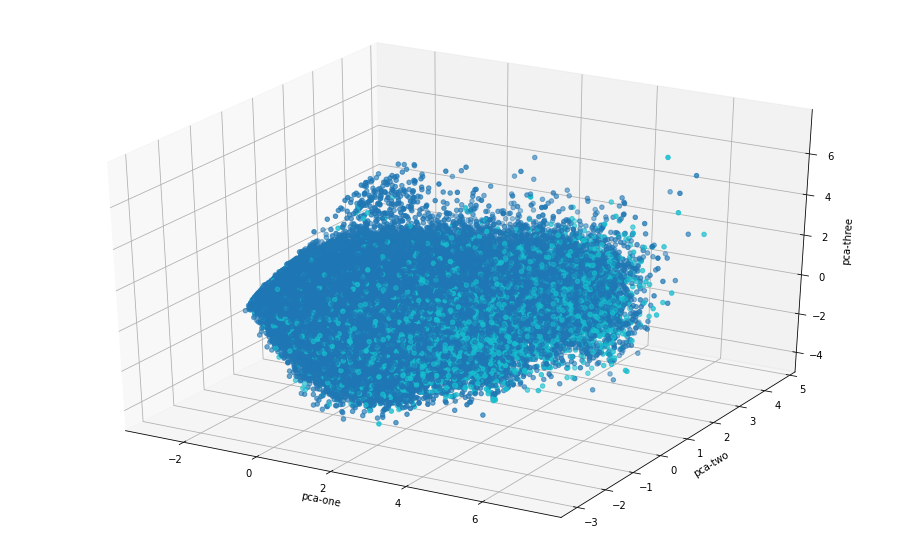

In [16]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=x_pca["PC1"], 
    ys=x_pca["PC2"], 
    zs=x_pca["PC3"], 
    c=y_train["HeartDiseaseorAttack"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## BaseLine model

Let's construct baseline model and test it on our original data (without over/under sampling). Since data with class =0 are more than data with class =1 in our dataset and we have imbalanced dataset, so we can construct baseline model that predicts all of the inputs as class = 0

In [ ]:
def baseline(X):
  y_pred = []
  for i in range(len(X)):
    y_pred.append(0)
  return y_pred

def confusion_matrix(y_test, y_pred):
    df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = [0, 1],
                  columns = [0, 1])
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
y_pred = baseline(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     41214
         1.0       0.00      0.00      0.00      4743

    accuracy                           0.90     45957
   macro avg       0.45      0.50      0.47     45957
weighted avg       0.80      0.90      0.85     45957



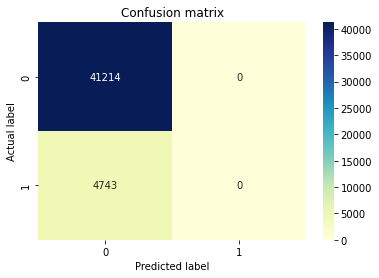

In [ ]:
confusion_matrix(y_test, y_pred)

using autoencoder for understanding structure of healthy people, or doing upsampling or downsampling.

## MLP classification

### Prepare data

For MLP we used `Pytorch`. in pytorch we should create class for our dataset then create loader for train and test data and then train the model.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

torch.manual_seed(0)

In [ ]:
class Heart(Dataset):
    def __init__(self, X, y):
        self.n_samples = X.shape[0]
        # convert DataFrame to numpy array
        X = X.to_numpy()
        y = y.to_numpy()
        # convert numpy to tensor
        self.x_data = torch.from_numpy(X.astype(np.float32)) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(y.astype(np.float32)) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


Let's pass the X_train_somte, X_test, y_train-somte and y_test from EDA section.

In [ ]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,HeartDiseaseorAttack
82362,1.0,0.0,1.0,-0.249055,1.0,0.0,-0.448896,0.0,0.0,0.0,0.0,1.0,0.0,2.251163,3.438176,2.796650,1.0,0.0,0.617706,-0.988815,-2.337071,0.0
251920,0.0,0.0,1.0,-1.426816,1.0,0.0,-0.448896,1.0,1.0,1.0,0.0,1.0,0.0,-0.565182,-0.454350,-0.517075,0.0,0.0,0.940686,0.019086,1.008672,0.0
188598,1.0,0.0,1.0,2.400908,0.0,0.0,-0.448896,1.0,1.0,1.0,0.0,1.0,0.0,1.312382,-0.065098,0.035213,1.0,0.0,-0.028253,-0.988815,0.052746,0.0
171570,1.0,1.0,1.0,-0.396275,1.0,0.0,-0.448896,0.0,1.0,1.0,0.0,1.0,0.0,-1.503964,-0.454350,-0.517075,0.0,1.0,0.617706,-0.988815,1.008672,0.0
71721,1.0,1.0,1.0,0.487046,0.0,1.0,2.312886,0.0,1.0,1.0,0.0,1.0,0.0,0.373600,-0.454350,2.796650,1.0,0.0,1.263665,0.019086,-1.381144,1.0


In [ ]:
train_normal = train[train['HeartDiseaseorAttack']==0]
print(f'train normal shape : {train_normal.shape}')

train normal shape : (164850, 22)


In [ ]:
X_train_normal = train_normal.drop(columns='HeartDiseaseorAttack')
y_train_normal = pd.DataFrame(train_normal['HeartDiseaseorAttack'])

In [ ]:
# Create data
train_data = Heart(X_train_normal, y_train_normal)
test_data = Heart(X_test, y_test)

In [ ]:
# get first sample of train data
x_sample, y_sample = train_data[0]
print(f'elements of x_sample : \n{x_sample[:10]} \nand y_sample : \n{y_sample}')
print(f'x_sample shape : {x_sample.shape} and y_sample shape : {y_sample.shape}')

elements of x_sample : 
tensor([ 1.0000,  0.0000,  1.0000, -0.2491,  1.0000,  0.0000, -0.4489,  0.0000,
         0.0000,  0.0000]) 
and y_sample : 
tensor([0.])
x_sample shape : torch.Size([21]) and y_sample shape : torch.Size([1])


Let's create dataloders for train and test dataset.

In [ ]:
# set batch size
# we can define different batch sizes for train and test loaders
BATCH_SIZE=128

In [ ]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = False) 
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

print(f'length of train data is : {len(train_data)} and length of train loader is : {len(train_loader)}')
print(f'length of test data is : {len(test_data)} and length of test loader is : {len(test_loader)}')

length of train data is : 164850 and length of train loader is : 1288
length of test data is : 45957 and length of test loader is : 360


In [ ]:
# get an example of train loader
example= iter(train_loader)

# unpack example
sample_x,sample_y = example.next()
print(f'samples shape : {sample_x.shape} ,labels shape : {sample_y.shape}')

samples shape : torch.Size([128, 21]) ,labels shape : torch.Size([128, 1])


### Create Model

add more layers and 50 epoches is good.

In [ ]:
# create neural network class
class NeuralNet(nn.Module):
  def __init__(self, input_size, num_classes):
    super(NeuralNet, self).__init__()
    self.fc = nn.Sequential(
    nn.Linear(input_size, 10),
    # nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(10, 10),
    # nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid())

  def forward(self,x):
    out = self.fc(x)
    return out

Let's define necessary functions for train, evaluate and test the model.


In [ ]:
# define a function to calculate accuracy
def accuracy(y_pred, y_act):
  y_pred = torch.round(y_pred)
  correct = (y_pred == y_act)
  acc = correct.sum()/len(correct)
  acc = torch.round(acc*100)
  return acc

# define a function for training a model
def train_fun(model1, train_loader):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model1.train() # train the model
  loop = tqdm(enumerate(train_loader), total = total_step, leave = False)

  for i, batch in loop:
    optimizer.zero_grad()
    x, y = batch # retrieve x and y
    x = x.to(device)
    y = y.to(device)
    y_pred = model1(x)
    loss_train = criterion(y_pred, y)
    acc_train = accuracy(y_pred, y)
    loss_train.backward()
    optimizer.step()

    train_epoch_loss += loss_train.item()
    train_epoch_acc += acc_train.item()
    loop.set_description(f'Epoch : [{epoch}/{NUM_EPOCH}]')
    loop.set_postfix(loss = loss_train.item(), accuracy = acc_train.item()) 
  
  train_loss.append(train_epoch_loss/len(train_loader))
  train_acc.append(train_epoch_acc/len(train_loader))  
      
  # # if you want to monitor your model in tensorboard   
  # writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch)
  # writer.add_scalar('training accuracy',train_epoch_acc/len(train_loader) , epoch)
  return train_loss, train_acc

# define a function for evaluating model
def evaluate(model1, valid_loader):
  with torch.no_grad():
    model1.eval()
    val_epoch_loss = 0
    val_epoch_acc = 0

    for batch in valid_loader:
      x, y = batch
      x = x.to(device)
      y = y.to(device)
      y_pred_val = model1(x)
      loss_valid = criterion(y_pred_val, y)
      acc_valid = accuracy(y_pred_val, y) 
      val_epoch_loss += loss_valid.item()
      val_epoch_acc += acc_valid.item()

    valid_loss.append(val_epoch_loss/len(valid_loader))
    valid_acc.append(val_epoch_acc/len(valid_loader))  

    # writer.add_scalar('validation loss',val_epoch_loss/len(valid_loader) , epoch)
    # writer.add_scalar('validation accuracy',val_epoch_acc/len(valid_loader) , epoch)
  return valid_loss, valid_acc

# define a function for evaluating model on test set
def test(model1, test_loader):
  y_pred_test = []
  y_actual_test = []

  model1.eval()
  with torch.no_grad():
    n_true = 0
    n_total = 0
    n_class_correct = [0 for i in range(num_class)]
    n_class_sample = [0 for i in range(num_class)]
  
    for batch in test_loader:
      x, y = batch
      output = model1(x)
      y_predtest = torch.round(output)
      n_true += (y_predtest == y).sum()
      n_total += y.size(0)

      for i in range(len(y_predtest)):
        y_pred_test.append(y_predtest[i])
        y_actual_test.append(y[i].item())

      for i in range(len(y_predtest)):
        lb = int(y[i].item())
        pred = y_predtest[i]
        if pred == lb:
          n_class_correct[lb] += 1
        n_class_sample[lb] += 1   

    print(f'accuracy of network on the {len(test_loader)} data is : {(n_true/n_total) *100}')
  
    for i in range(len(classes)):
      acc = 100.0 * n_class_correct[i] / n_class_sample[i]
      print(f'Accuracy of {classes[i]}: {acc} %')
  
  return y_pred_test, y_actual_test


### Parameter Tuning using Cross Validation

In [ ]:
# set parameters
INPUT_SIZE = X_train_smote.shape[1]
OUTPUT_SIZE = 1
NUM_EPOCH = 50
LR = 0.001

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
fold = StratifiedKFold(5) # shuffle false because we shuffled data in splitting train and test section
cv_scores = {'Accuracy' : []}

for fold, (train_ids, valid_ids) in enumerate(fold.split(X_train, y_train)):
  # sample elements randomly from a give list of ids, no replacement
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

  # create dataloader for train and valid data in this fold
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_subsampler)
  validloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_subsampler)

  model = NeuralNet(INPUT_SIZE, OUTPUT_SIZE)
  optimizer = torch.optim.Adam(model.parameters(), lr= LR)
  criterion = nn.BCELoss()
  scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.2)

  total_step = len(trainloader)
  train_loss, valid_loss = [], []
  train_acc, valid_acc = [], []

  for epoch in range(NUM_EPOCH):
    train_loss, train_acc = train_fun(model, trainloader)
    # writer.flush() 
    valid_loss, valid_acc = evaluate(model, validloader)   
    print(f'fold {fold} => train acc : {train_acc[-1]:0.2f}| train loss : {train_loss[-1]:0.2f}| valid acc : {valid_acc[-1]:0.2f}| valid loss : {valid_loss[-1]:0.2f}')
    scheduler.step()

  cv_scores['Accuracy'].append(valid_acc[-1])



fold 0 => train acc : 81.86| train loss : 0.38| valid acc : 89.65| valid loss : 0.28


fold 0 => train acc : 89.67| train loss : 0.27| valid acc : 89.78| valid loss : 0.26


fold 0 => train acc : 89.84| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 0 => train acc : 89.90| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 0 => train acc : 89.91| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 0 => train acc : 89.90| train loss : 0.26| valid acc : 90.01| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 89.96| valid loss : 0.26


fold 0 => train acc : 89.91| train loss : 0.26| valid acc : 90.09| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 89.99| valid loss : 0.26


fold 0 => train acc : 89.92| train loss : 0.26| valid acc : 89.98| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 89.99| valid loss : 0.26


fold 0 => train acc : 89.94| train loss : 0.26| valid acc : 90.03| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 90.04| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.06| valid loss : 0.26


fold 0 => train acc : 89.92| train loss : 0.26| valid acc : 90.03| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 90.06| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 90.04| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 90.01| valid loss : 0.26


fold 0 => train acc : 89.92| train loss : 0.26| valid acc : 90.03| valid loss : 0.26


fold 0 => train acc : 89.92| train loss : 0.26| valid acc : 90.04| valid loss : 0.26


fold 0 => train acc : 89.97| train loss : 0.26| valid acc : 90.06| valid loss : 0.26


fold 0 => train acc : 89.96| train loss : 0.26| valid acc : 90.08| valid loss : 0.26


fold 0 => train acc : 89.97| train loss : 0.26| valid acc : 90.04| valid loss : 0.26


fold 0 => train acc : 89.94| train loss : 0.26| valid acc : 90.07| valid loss : 0.26


fold 0 => train acc : 89.97| train loss : 0.26| valid acc : 90.06| valid loss : 0.26


fold 0 => train acc : 89.96| train loss : 0.26| valid acc : 90.05| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.05| valid loss : 0.26


fold 0 => train acc : 89.94| train loss : 0.26| valid acc : 90.03| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.06| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 89.99| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.01| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.04| valid loss : 0.26


fold 0 => train acc : 89.96| train loss : 0.26| valid acc : 90.08| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.07| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 90.06| valid loss : 0.26


fold 0 => train acc : 89.94| train loss : 0.26| valid acc : 90.06| valid loss : 0.26


fold 0 => train acc : 89.98| train loss : 0.26| valid acc : 90.03| valid loss : 0.26


fold 0 => train acc : 89.96| train loss : 0.26| valid acc : 90.00| valid loss : 0.26


fold 0 => train acc : 89.94| train loss : 0.26| valid acc : 90.07| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.01| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 90.05| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 90.06| valid loss : 0.26


fold 0 => train acc : 89.96| train loss : 0.26| valid acc : 90.03| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.05| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.03| valid loss : 0.26


fold 0 => train acc : 89.94| train loss : 0.26| valid acc : 90.05| valid loss : 0.26


fold 0 => train acc : 89.98| train loss : 0.26| valid acc : 90.01| valid loss : 0.26


fold 0 => train acc : 89.95| train loss : 0.26| valid acc : 90.05| valid loss : 0.26


fold 0 => train acc : 89.94| train loss : 0.26| valid acc : 90.06| valid loss : 0.26


fold 0 => train acc : 89.93| train loss : 0.26| valid acc : 90.03| valid loss : 0.26


fold 1 => train acc : 89.71| train loss : 0.34| valid acc : 89.73| valid loss : 0.27


fold 1 => train acc : 89.90| train loss : 0.26| valid acc : 89.86| valid loss : 0.26


fold 1 => train acc : 89.92| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 1 => train acc : 89.97| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 1 => train acc : 89.97| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 1 => train acc : 89.97| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 1 => train acc : 89.94| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.94| valid loss : 0.26


fold 1 => train acc : 89.98| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 1 => train acc : 90.00| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 1 => train acc : 89.96| train loss : 0.26| valid acc : 89.93| valid loss : 0.26


fold 1 => train acc : 90.01| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.96| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.89| valid loss : 0.26


fold 1 => train acc : 89.98| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 1 => train acc : 90.00| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.98| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 1 => train acc : 90.01| train loss : 0.26| valid acc : 89.89| valid loss : 0.26


fold 1 => train acc : 90.00| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.89| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 1 => train acc : 90.00| train loss : 0.26| valid acc : 89.87| valid loss : 0.26


fold 1 => train acc : 90.01| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 1 => train acc : 89.98| train loss : 0.26| valid acc : 89.89| valid loss : 0.26


fold 1 => train acc : 90.02| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 90.01| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.93| valid loss : 0.26


fold 1 => train acc : 90.01| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 1 => train acc : 90.00| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.98| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 1 => train acc : 89.97| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 90.01| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 1 => train acc : 90.00| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 90.03| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 1 => train acc : 90.01| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 90.01| train loss : 0.26| valid acc : 89.93| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.87| valid loss : 0.26


fold 1 => train acc : 89.99| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 90.01| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 1 => train acc : 89.98| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 1 => train acc : 89.98| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 1 => train acc : 89.98| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 1 => train acc : 90.00| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 1 => train acc : 89.98| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 2 => train acc : 86.85| train loss : 0.35| valid acc : 89.69| valid loss : 0.27


fold 2 => train acc : 89.78| train loss : 0.26| valid acc : 89.94| valid loss : 0.26


fold 2 => train acc : 89.96| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.87| valid loss : 0.26


fold 2 => train acc : 89.95| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 89.95| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 89.94| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 2 => train acc : 89.97| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.94| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.89| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 2 => train acc : 89.97| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.89| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 2 => train acc : 90.00| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.96| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 2 => train acc : 90.01| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 90.00| train loss : 0.26| valid acc : 89.89| valid loss : 0.26


fold 2 => train acc : 90.00| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.89| valid loss : 0.26


fold 2 => train acc : 90.00| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.94| valid loss : 0.26


fold 2 => train acc : 90.01| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 2 => train acc : 90.01| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 2 => train acc : 90.00| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 2 => train acc : 90.01| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 2 => train acc : 90.02| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 2 => train acc : 90.02| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 2 => train acc : 90.00| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 2 => train acc : 90.00| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.94| valid loss : 0.26


fold 2 => train acc : 90.02| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 2 => train acc : 90.03| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.89| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.96| valid loss : 0.26


fold 2 => train acc : 89.99| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 2 => train acc : 89.98| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 2 => train acc : 90.01| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 3 => train acc : 89.66| train loss : 0.30| valid acc : 89.67| valid loss : 0.26


fold 3 => train acc : 89.70| train loss : 0.26| valid acc : 89.66| valid loss : 0.26


fold 3 => train acc : 89.82| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 3 => train acc : 89.91| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 3 => train acc : 89.94| train loss : 0.26| valid acc : 89.94| valid loss : 0.26


fold 3 => train acc : 89.95| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 3 => train acc : 89.94| train loss : 0.26| valid acc : 89.93| valid loss : 0.26


fold 3 => train acc : 89.94| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 3 => train acc : 89.95| train loss : 0.26| valid acc : 89.94| valid loss : 0.26


fold 3 => train acc : 89.96| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.98| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.93| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 3 => train acc : 89.99| train loss : 0.26| valid acc : 89.98| valid loss : 0.26


fold 3 => train acc : 89.99| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 3 => train acc : 89.96| train loss : 0.26| valid acc : 89.92| valid loss : 0.26


fold 3 => train acc : 89.96| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 3 => train acc : 89.95| train loss : 0.26| valid acc : 89.94| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.99| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.96| valid loss : 0.26


fold 3 => train acc : 89.96| train loss : 0.26| valid acc : 89.99| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.93| valid loss : 0.26


fold 3 => train acc : 89.96| train loss : 0.26| valid acc : 90.01| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.93| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.96| train loss : 0.26| valid acc : 89.94| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.91| valid loss : 0.26


fold 3 => train acc : 89.99| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 90.03| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 3 => train acc : 89.96| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 3 => train acc : 89.99| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.99| train loss : 0.26| valid acc : 90.00| valid loss : 0.26


fold 3 => train acc : 89.99| train loss : 0.26| valid acc : 89.96| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.98| valid loss : 0.26


fold 3 => train acc : 89.94| train loss : 0.26| valid acc : 89.95| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.97| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.96| valid loss : 0.26


fold 3 => train acc : 89.98| train loss : 0.26| valid acc : 89.99| valid loss : 0.26


fold 3 => train acc : 89.97| train loss : 0.26| valid acc : 89.98| valid loss : 0.26


fold 4 => train acc : 89.43| train loss : 0.32| valid acc : 89.68| valid loss : 0.26


fold 4 => train acc : 89.76| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 4 => train acc : 89.89| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


fold 4 => train acc : 89.90| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 4 => train acc : 89.93| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 4 => train acc : 89.95| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 4 => train acc : 89.92| train loss : 0.26| valid acc : 89.75| valid loss : 0.26


fold 4 => train acc : 89.92| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 4 => train acc : 89.95| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 4 => train acc : 89.94| train loss : 0.26| valid acc : 89.76| valid loss : 0.26


fold 4 => train acc : 89.96| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.87| valid loss : 0.26


fold 4 => train acc : 89.95| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.96| train loss : 0.26| valid acc : 89.87| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 4 => train acc : 89.96| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.82| valid loss : 0.26


fold 4 => train acc : 89.95| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 4 => train acc : 89.96| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 4 => train acc : 89.96| train loss : 0.26| valid acc : 89.86| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 4 => train acc : 89.96| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.86| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.94| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 4 => train acc : 89.99| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 4 => train acc : 90.00| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.96| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.84| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 4 => train acc : 89.96| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 4 => train acc : 89.96| train loss : 0.26| valid acc : 89.88| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.81| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 4 => train acc : 89.99| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 4 => train acc : 89.94| train loss : 0.26| valid acc : 89.83| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.85| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.87| valid loss : 0.26


fold 4 => train acc : 89.97| train loss : 0.26| valid acc : 89.82| valid loss : 0.26


fold 4 => train acc : 89.98| train loss : 0.26| valid acc : 89.90| valid loss : 0.26


In [ ]:
mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}  
print(f"mean accuracy using 5 foldCV : {mean_cv_scores['Accuracy']:0.2f}")

mean accuracy using 5 foldCV : 89.95


### Train the model

After tune parameters from previous section, we should create the model and train it.

In [ ]:
# create model
model = NeuralNet(INPUT_SIZE, OUTPUT_SIZE)

# create loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)
scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.2)
total_step = len(train_loader)

In [ ]:
model

NeuralNet(
  (fc): Sequential(
    (0): Linear(in_features=21, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
train_loss, train_acc  = [], []

for epoch in range(NUM_EPOCH):
  train_loss, train_acc = train_fun(model, train_loader)
  # writer.flush()   
  scheduler.step()

In [ ]:
torch.save(model, '/content/drive/MyDrive/ML_Dr.sajedi/final-proj_mlp1_over3') # model1 with 10 epochs

In [ ]:
def plot_loss(loss):
  plt.plot(loss, label="Training loss")
  plt.legend(frameon=False)
  plt.xticks([i for i in range(0, NUM_EPOCH)])
  plt.xlabel("epoch")
  plt.ylabel("loss value")
  plt.title("Loss function for each epoch") 
  plt.show()

def plot_accuracy(acc):
  plt.plot(acc, label="Training accuracy")
  plt.legend(frameon=False)
  plt.xticks([i for i in range(0, NUM_EPOCH)])
  plt.xlabel("epoch")
  plt.ylabel("accuracy value")
  plt.title("Accuracy for each epoch")
  plt.show()

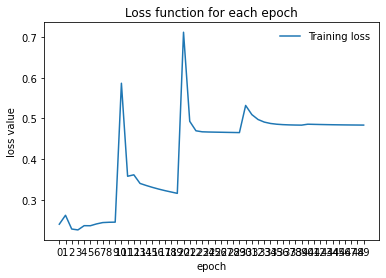

In [ ]:
plot_loss(train_loss)

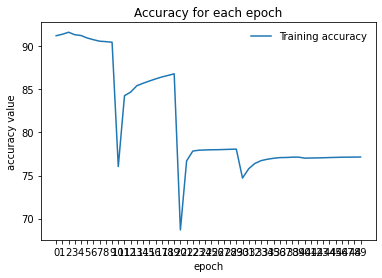

In [ ]:
plot_accuracy(train_acc)

In [ ]:
print(f'training loss on last epoch : {train_loss[-1]}')
print('-'*20)
print(f'training accuracy on last epoch : {train_acc[-1]}')

training loss on last epoch : 0.4837741676879966
--------------------
training accuracy on last epoch : 77.15062111801242


### Test the model 

In [ ]:
num_class=2
classes = ['0', '1']

y_pred_test, y_actual_test = test(model, test_loader)

accuracy of network on the 180 data is : 71.82366180419922
Accuracy of 0: 70.80846314359198 %
Accuracy of 1: 80.64516129032258 %


In [ ]:
print(classification_report(y_actual_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82     41214
         1.0       0.24      0.81      0.37      4743

    accuracy                           0.72     45957
   macro avg       0.61      0.76      0.59     45957
weighted avg       0.89      0.72      0.77     45957



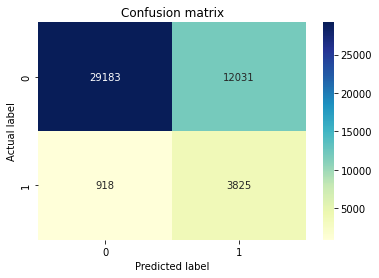

In [ ]:
confusion_matrix(y_actual_test, y_pred_test)

In [ ]:
def roc_plot(y, y_pred):
  fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='model')
  display.plot()
  plt.plot([0, 1], [0, 1], "k--", lw=2)
  plt.title("ROC")
  plt.show()


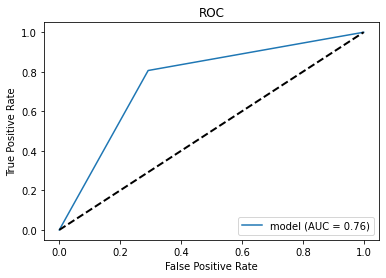

In [ ]:
roc_plot(y_actual_test, y_pred_test)

بسیار عمللکرد بدی داره حتی از رندوم هم بدتر

## AutoEncoder

### Create Model

In [ ]:
#21 -> 10 -> 21
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Create linear encoder with Linear layer followed by Relu activation function
        self.encoder = nn.Sequential(
            torch.nn.Linear(input_size, 14),
            torch.nn.ReLU(),
            torch.nn.Linear(14, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.ReLU()
        )
          
        # Create linear decoder with Linear layer followed by Relu activation function
        self.decoder = nn.Sequential(
            torch.nn.Linear(10, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 14),
            torch.nn.ReLU(),
            torch.nn.Linear(14, input_size),
            torch.nn.ReLU()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

let's define necessary functions.

In [ ]:
# define a function for training a model
def train_ae(model1, train_loader):
  train_epoch_loss = 0
  model1.train() # train the model
  loop = tqdm(enumerate(train_loader), total = total_step, leave = False)

  for i, batch in loop:
    optimizer.zero_grad()
    x, y = batch # retrieve x and y
    x = x.to(device)
    _, x_pred = model1(x)
    loss_train = criterion(x_pred, x)
    loss_train.backward()
    optimizer.step()

    train_epoch_loss += loss_train.item()
    loop.set_description(f'Epoch : [{epoch}/{NUM_EPOCH}]')
    loop.set_postfix(loss = loss_train.item()) 
  
  train_loss.append(train_epoch_loss/len(train_loader)) 
      
  # if you want to monitor your model in tensorboard   
  # writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch)
  return train_loss

# define a function for evaluating model
def evaluate_ae(model1, valid_loader):
  with torch.no_grad():
    model1.eval()
    val_epoch_loss = 0

    for batch in valid_loader:
      x, y = batch
      x = x.to(device)
      _, x_pred_val = model1(x)
      loss_valid = criterion(x_pred_val, x)
      val_epoch_loss += loss_valid.item()

    valid_loss.append(val_epoch_loss/len(valid_loader)) 

    # writer.add_scalar('validation loss',val_epoch_loss/len(valid_loader) , epoch)
  return valid_loss

# define a function for evaluating model on test set
def test_ae(model1, test_loader):
  model1.eval()
  with torch.no_grad():
    test_epoch_loss = 0

    for batch in test_loader:
      x, y = batch
      _, x_pred_test = model1(x)
      loss_test = criterion(x_pred_test, x)
      test_epoch_loss += loss_test.item()
    
    test_loss.append(test_epoch_loss/len(test_loader))
  return test_loss

### Parameter Tuning using Cross Validaton

In [ ]:
INPUT_SIZE = X.shape[1]
NUM_EPOCH = 30
LR = 0.01

In [ ]:
fold = StratifiedKFold(5) # shuffle false because we shuffled data in splitting train and test section

for fold, (train_ids, valid_ids) in enumerate(fold.split(X_train_normal, y_train_normal)):
  # sample elements randomly from a give list of ids, no replacement
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

  # create dataloader for train and valid data in this fold
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_subsampler)
  validloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_subsampler)

  model = Autoencoder(INPUT_SIZE)
  optimizer = torch.optim.Adam(model.parameters(), lr= LR)
  criterion = nn.MSELoss()
  scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.3)

  total_step = len(trainloader)
  train_loss, valid_loss = [], []

  for epoch in range(NUM_EPOCH):
    train_loss = train_ae(model, trainloader)
    # writer.flush() 
    valid_loss = evaluate_ae(model, validloader)   
    print(f'fold {fold} => train loss : {train_loss[-1]:0.2f}| valid loss : {valid_loss[-1]:0.2f}')
    scheduler.step()

fold 0 => train loss : 0.34| valid loss : 0.31


fold 0 => train loss : 0.30| valid loss : 0.28


fold 0 => train loss : 0.27| valid loss : 0.27


fold 0 => train loss : 0.26| valid loss : 0.26


fold 0 => train loss : 0.26| valid loss : 0.26


fold 0 => train loss : 0.26| valid loss : 0.26


fold 0 => train loss : 0.26| valid loss : 0.26


fold 0 => train loss : 0.26| valid loss : 0.26


fold 0 => train loss : 0.26| valid loss : 0.26


fold 0 => train loss : 0.26| valid loss : 0.26


fold 1 => train loss : 0.30| valid loss : 0.27


fold 1 => train loss : 0.27| valid loss : 0.26


fold 1 => train loss : 0.26| valid loss : 0.26


fold 1 => train loss : 0.26| valid loss : 0.26


fold 1 => train loss : 0.26| valid loss : 0.26


fold 1 => train loss : 0.26| valid loss : 0.26


fold 1 => train loss : 0.26| valid loss : 0.26


fold 1 => train loss : 0.26| valid loss : 0.26


fold 1 => train loss : 0.26| valid loss : 0.26


fold 1 => train loss : 0.26| valid loss : 0.26


fold 2 => train loss : 0.30| valid loss : 0.25


fold 2 => train loss : 0.24| valid loss : 0.24


fold 2 => train loss : 0.23| valid loss : 0.23


fold 2 => train loss : 0.23| valid loss : 0.23


fold 2 => train loss : 0.23| valid loss : 0.23


fold 2 => train loss : 0.23| valid loss : 0.23


fold 2 => train loss : 0.23| valid loss : 0.23


fold 2 => train loss : 0.23| valid loss : 0.23


fold 2 => train loss : 0.23| valid loss : 0.23


fold 2 => train loss : 0.23| valid loss : 0.23


fold 3 => train loss : 0.37| valid loss : 0.35


fold 3 => train loss : 0.34| valid loss : 0.34


fold 3 => train loss : 0.33| valid loss : 0.33


fold 3 => train loss : 0.33| valid loss : 0.33


fold 3 => train loss : 0.33| valid loss : 0.33


fold 3 => train loss : 0.33| valid loss : 0.33


fold 3 => train loss : 0.32| valid loss : 0.32


fold 3 => train loss : 0.32| valid loss : 0.32


fold 3 => train loss : 0.32| valid loss : 0.32


fold 3 => train loss : 0.32| valid loss : 0.32


fold 4 => train loss : 0.42| valid loss : 0.37


fold 4 => train loss : 0.36| valid loss : 0.35


fold 4 => train loss : 0.35| valid loss : 0.35


fold 4 => train loss : 0.35| valid loss : 0.34


fold 4 => train loss : 0.34| valid loss : 0.34


fold 4 => train loss : 0.34| valid loss : 0.34


fold 4 => train loss : 0.34| valid loss : 0.34


fold 4 => train loss : 0.34| valid loss : 0.34


fold 4 => train loss : 0.34| valid loss : 0.34


fold 4 => train loss : 0.34| valid loss : 0.34


max loss on validation data : 0.34

### Train the model

In [ ]:
# create model
model = Autoencoder(INPUT_SIZE)

# create loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)
scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.3)
total_step = len(train_loader)


In [ ]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=21, out_features=14, bias=True)
    (1): ReLU()
    (2): Linear(in_features=14, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=14, bias=True)
    (3): ReLU()
    (4): Linear(in_features=14, out_features=21, bias=True)
    (5): ReLU()
  )
)

In [ ]:
train_loss = []

for epoch in range(NUM_EPOCH):
  train_loss = train_ae(model, train_loader)
  # writer.flush()   
  scheduler.step()

In [ ]:
PATH = '/content/drive/MyDrive/ML_Dr.sajedi/final-proj_aeth.pt'
torch.save(model.state_dict(), PATH) # Save

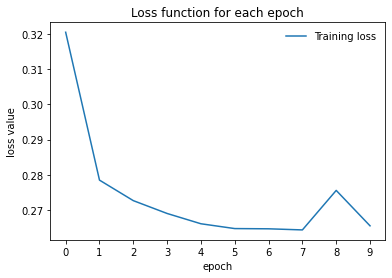

In [ ]:
plot_loss(train_loss)

In [ ]:
model1 = 

In [ ]:
def test_predict(model, test_loader, threshold):
  loss = []
  model.eval()
  for batch in test_loader:
    x, y = batch
    _, x_pred_test = model(x)
    diff = x - x_pred_test
    diff = diff.detach().numpy()
    mse = np.mean(np.power(diff, 2), axis=1)
    mse = mse.tolist()
    loss.extend(mse)
  # return loss
  label = pred_label(loss, threshold)
  return label

def pred_label(loss, threshold):
  for i in range(len(loss)):
    if loss[i]<= threshold:
      loss[i] = 0
    else:
      loss[i] = 1  
  return loss      

In [ ]:
len(test_loader)

360

In [ ]:
loss = test_predict(model, test_loader, 0.34)

In [ ]:
len(loss)

45957

In [ ]:
loss.count(1)

11277

In [ ]:
y_test.to_numpy()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

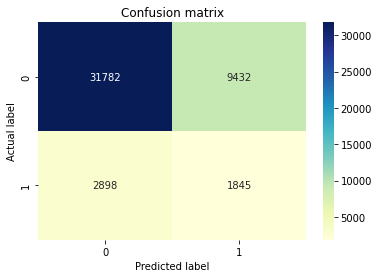

In [ ]:
confusion_matrix(y_test.to_numpy(), loss)

In [ ]:
print(classification_report(y_test.to_numpy(), loss))

              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84     41214
         1.0       0.16      0.39      0.23      4743

    accuracy                           0.73     45957
   macro avg       0.54      0.58      0.53     45957
weighted avg       0.84      0.73      0.77     45957



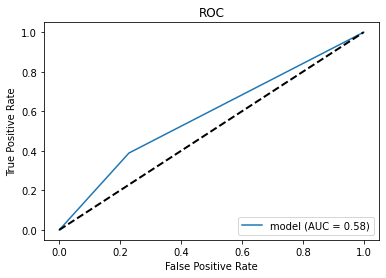

In [ ]:
roc_plot(y_test.to_numpy(), loss)